# Top Mass DCTR 1D - $m_{jjj}$

This notebook attempts to train and validate a DCTR model that reweights __only__ $m_T = 172.5 \rightarrow 175.0$ using only reconstructed hadronic mass $m_{jjj}$ for each event

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Process Data

In [3]:
# Path to downloaded data from Zenodo
data_dir0 = '/data1/users/aandreassen/DCTRFitting/'
data_dir1 = '/data1/users/asuresh/DCTRFitting/'

In [4]:
# fetch m_jjj vals from default dataset
train_dataset_0_mjjj = np.load(data_dir0 + 'part_172_5_6j_obs.npy')[:, :1]
train_dataset_0_mjjj_x4 = np.load(data_dir1 +
                                  'part_172_5_6j_obs_x4.npy')[:, :1]
# combine orignal and x4 samples
train_dataset_0_mjjj = np.concatenate(
    (train_dataset_0_mjjj, train_dataset_0_mjjj_x4))

print(np.shape(train_dataset_0_mjjj))

# fetch m_jjj vals from varied dataset
train_dataset_1_mjjj = np.load(data_dir0 + 'part_175_0_6j_obs.npy')[:, :1]
train_dataset_1_mjjj_x4 = np.load(data_dir1 +
                                  'part_175_0_6j_obs_x4.npy')[:, :1]
# combine orignal and x4 samples
train_dataset_1_mjjj = np.concatenate(
    (train_dataset_1_mjjj,
     train_dataset_1_mjjj_x4))  #[:len(train_dataset_0_mjjj)]

print(np.shape(train_dataset_1_mjjj))

(287065, 1)
(294294, 1)


The model will see an unequal number of events from the uniformly sampled mass data and the fixed mass data. We will have to correct this with a liklihood ratio factor when reweighting.

In [5]:
X0 = train_dataset_0_mjjj
X1 = train_dataset_1_mjjj

print(len(X1)/len(X0)) # different sizes if != 1

1.0251824499677773


In [6]:
Y0 = np.zeros_like(X0[:,0])
Y1 = np.ones_like(X1[:,0])

In [7]:
X = np.concatenate((X0, X1), axis = 0)
X /= 100.

Y = np.concatenate((Y0, Y1), axis = 0)
Y = to_categorical(Y, num_classes=2)

In [8]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.2, shuffle=True)

In [9]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(465088, 1)
(465088, 2)
(116271, 1)
(116271, 2)


## Build Model

In [10]:
inputs = Input((1,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr = Model(inputs = inputs, outputs = outputs)
dctr.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train model

Model has a tendency to initialize at trivial minima of the loss function (loss ~ 8 or loss ~7); the mode's outputs are all [1, 0] or all [0, 1] respecively in these cases. We do 100 iterations of initializations to explore the fraction of initiziations that succeed in being able to train a non-trivial model(loss after first epoch ~1), and keep the weights from such a model to complete the rest of training.

In [11]:
n_fail1 = 0
n_fail2 = 0
n_succ = 0
iterations = 100

dctr_weights = 0

for i in range(iterations):
    print("Iteration: ", i)

    K.clear_session()
    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    dctr = Model(inputs=inputs, outputs=outputs)
    dctr.compile(loss='categorical_crossentropy',
                 optimizer='Adam',
                 metrics=['accuracy'])

    history = dctr.fit(X_train,
                       Y_train,
                       epochs=1,
                       batch_size=1000,
                       validation_data=(X_val, Y_val),
                       verbose=2)
    if history.history['val_loss'][0] > 8:
        # Fail case 1, model output [1, 0] for all preds
        n_fail1 += 1
        print("Fail (case 1)")
        pass
    elif history.history['val_loss'][0] > 7:
        # Fail case 2, , model output [0, 1] for all preds
        n_fail2 += 1
        print("Fail (case 2)")
        pass
    else:  
        # success
        n_succ += 1
        print("Success")
        # remember successful weights
        dctr_weights = dctr.get_weights()
        pass


n_fail = n_fail1 + n_fail2

Iteration:  0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 465088 samples, validate on 116271 samples
Epoch 1/1





 - 3s - loss: 0.6931 - acc: 0.5050 - val_loss: 0.6932 - val_acc: 0.4962
Success
Iteration:  1
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6932 - acc: 0.5041 - val_loss: 0.6930 - val_acc: 0.5052
Success
Iteration:  2
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6932 - acc: 0.5039 - val_loss: 0.6931 - val_acc: 0.5006
Success
Iteration:  3
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6931 - acc: 0.5048 - val_loss: 0.6931 - val_acc: 0.5054
Success
Iteration:  4
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6934 - acc: 0.5045 - val_loss: 0.6936 - val_acc: 0.4946
Success
Iteration:  5
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6933 - acc: 0.5034 - val

Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6932 - acc: 0.5045 - val_loss: 0.6933 - val_acc: 0.4948
Success
Iteration:  38
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6934 - acc: 0.5040 - val_loss: 0.6931 - val_acc: 0.5054
Success
Iteration:  39
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6932 - acc: 0.5043 - val_loss: 0.6931 - val_acc: 0.5054
Success
Iteration:  40
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6933 - acc: 0.5041 - val_loss: 0.6930 - val_acc: 0.5054
Success
Iteration:  41
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 3s - loss: 0.6932 - acc: 0.5040 - val_loss: 0.6930 - val_acc: 0.5167
Success
Iteration:  42
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6933 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.4989
Success
Iteration:  43
Train on 465088 samples, validate on 116271 samples
Epoch 

 - 2s - loss: 0.6931 - acc: 0.5050 - val_loss: 0.6931 - val_acc: 0.5054
Success
Iteration:  90
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6932 - acc: 0.5031 - val_loss: 0.6930 - val_acc: 0.5054
Success
Iteration:  91
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6931 - acc: 0.5052 - val_loss: 0.6930 - val_acc: 0.5053
Success
Iteration:  92
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6933 - acc: 0.5037 - val_loss: 0.6931 - val_acc: 0.5054
Success
Iteration:  93
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6933 - acc: 0.5034 - val_loss: 0.6932 - val_acc: 0.5054
Success
Iteration:  94
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6934 - acc: 0.5040 - val_loss: 0.6930 - val_acc: 0.5054
Success
Iteration:  95
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 2s - loss: 0.6933 - acc: 0.5038 - val_loss: 0.6931 - va

In [12]:
print("Number of initializations failed: ", n_fail, "/", iterations)
print("Percentage of initializations failed:", (100*n_fail/iterations), "%")

print("Number of initializations succeeded: ", n_succ, "/", iterations)
print("Percentage of initializations succeeded:", (100*n_succ/iterations), "%")

Number of initializations failed:  0 / 100
Percentage of initializations failed: 0.0 %
Number of initializations succeeded:  100 / 100
Percentage of initializations succeeded: 100.0 %


### Finish training

In [13]:
earlystopping = EarlyStopping(patience=10, restore_best_weights=True)


try:
    dctr.set_weights(dctr_weights)
    history = dctr.fit(X_train,
                   Y_train,
                   epochs=200,
                   batch_size=1000,
                   validation_data=(X_val, Y_val),
                   callbacks=[earlystopping],
                   verbose=1)
except:
    print(
        "Model did not have any successful initializations, will not continue training."
    )

Train on 465088 samples, validate on 116271 samples
Epoch 1/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6931 - acc: 0.5049 - val_loss: 0.6932 - val_acc: 0.5054
Epoch 2/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6931 - acc: 0.5049 - val_loss: 0.6933 - val_acc: 0.5054
Epoch 3/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6930 - acc: 0.5062 - val_loss: 0.6929 - val_acc: 0.5065
Epoch 4/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6930 - acc: 0.5083 - val_loss: 0.6931 - val_acc: 0.5133
Epoch 5/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6930 - acc: 0.5080 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 6/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6929 - acc: 0.5100 - val_loss: 0.6929 - val_acc: 0.5056
Epoch 7/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6929 - acc: 0.5089 - val_loss: 

465088/465088 [==============================] - 2s 5us/step - loss: 0.6920 - acc: 0.5174 - val_loss: 0.6917 - val_acc: 0.5202
Epoch 60/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6919 - acc: 0.5185 - val_loss: 0.6922 - val_acc: 0.5104
Epoch 61/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6919 - acc: 0.5175 - val_loss: 0.6916 - val_acc: 0.5205
Epoch 62/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6919 - acc: 0.5175 - val_loss: 0.6917 - val_acc: 0.5184
Epoch 63/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6919 - acc: 0.5174 - val_loss: 0.6917 - val_acc: 0.5209
Epoch 64/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6920 - acc: 0.5179 - val_loss: 0.6921 - val_acc: 0.5189
Epoch 65/200
465088/465088 [==============================] - 2s 5us/step - loss: 0.6919 - acc: 0.5179 - val_loss: 0.6917 - val_acc: 0.5214


# Plot History

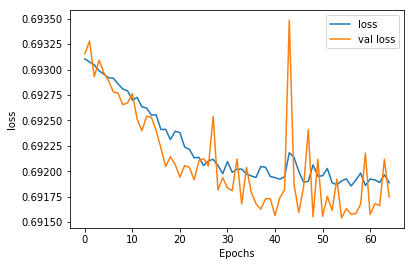

In [14]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

## Validation

### Load Datasets

In [15]:
test_dataset_0_mjjj = np.load(data_dir0 + 'part_172_5_6j_obs.npy')[:, :1]
test_dataset_1_mjjj = np.load(data_dir0 + 'part_175_0_6j_obs.npy')[:, :1]

print(np.shape(test_dataset_0_mjjj))
print(np.shape(test_dataset_1_mjjj))

(57710, 1)
(59119, 1)


In [16]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

### Define reweighting function

We must calculate two liklihood ratios during reweighting: the first because the training datasets were different sizes, and the second because the validation datasets are different sizes.

In [17]:
# Get predicted probabilities
def reweight(default_dataset_172_5):

    data_input = default_dataset_172_5/100.

    f = dctr.predict(data_input)
    weights = f[:, 1] / f[:, 0]
    return weights

### Get weights

In [18]:
weights = reweight(default_dataset_172_5=test_dataset_0_mjjj)

### Analyze weights

In [19]:
print(max(weights))
print(max(1/weights))

1.374267
1.1101617


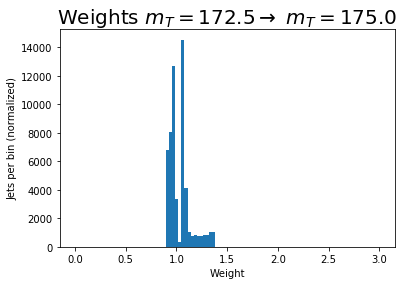

In [23]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
#plt.savefig("Weights: Top Reweighting (fixed mass DCTR): m_{jjj} only.png")
plt.show()

### Validating Reweighting

In [24]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

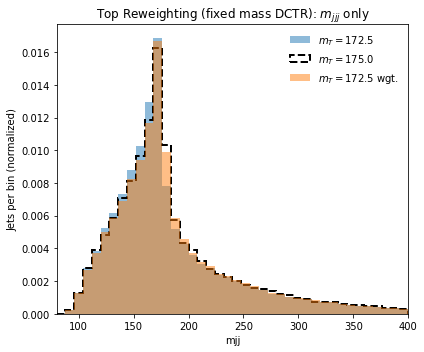

In [25]:
plt.figure(figsize=(6,5))
plt.title("Top Reweighting (fixed mass DCTR): $m_{jjj}$ only")
bins = np.linspace(80,400,41)
hist0 = plt.hist(test_dataset_0_mjjj, bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1_mjjj, bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0_mjjj, bins = bins, label = label_0 + ' wgt.', weights=weights, **plot_style_1)

plt.xlabel('mjj')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80,400])
make_legend()
#plt.savefig("Top Reweighting (fixed mass DCTR): m_{jjj} only.png")
plt.show()